# Single Layer Multiclass Classification

In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST,EMNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


/home/bikasherl/miniconda3/envs/bajra/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## MNNIST DATASET

In [2]:
train_data=MNIST(root='dataset/train/',train=True,download=True,transform=ToTensor())
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: dataset/train/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [3]:
test_data=MNIST(root='dataset/test/',train=False,download=True,transform=ToTensor())
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: dataset/test/
    Split: Test
    StandardTransform
Transform: ToTensor()

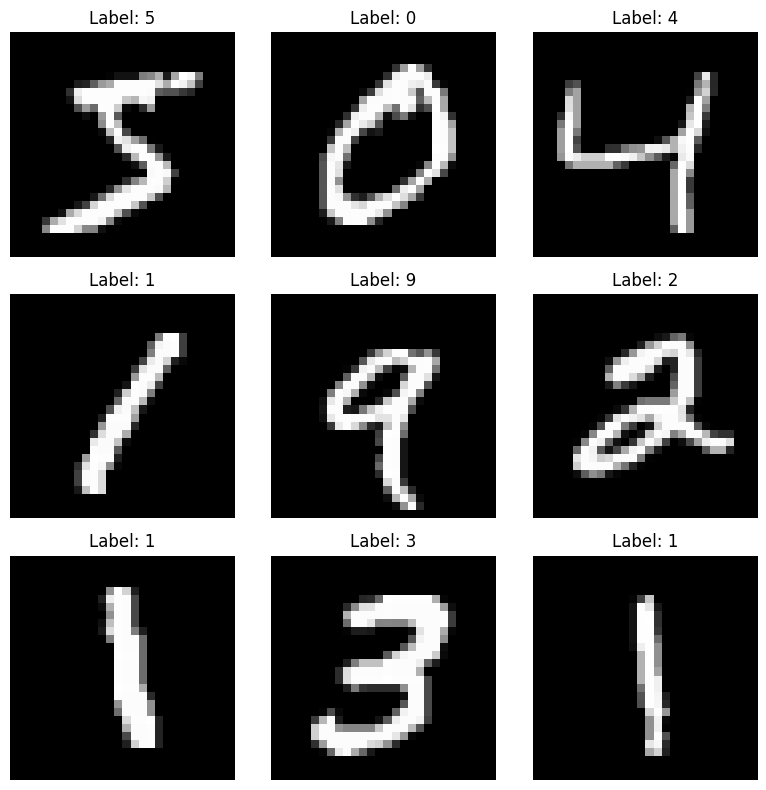

In [4]:
# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(8, 8))

# Plot images
for i in range(3):
    for j in range(3):
        img, label = train_data[i * 3 + j]  # Accessing each image and label
        axs[i, j].imshow(img.squeeze(),cmap='gray')
        axs[i, j].set_title(f'Label: {label}')
        axs[i, j].axis('off')  # Hide axis

plt.tight_layout()
plt.show()

In [5]:
# train set
X_train=torch.flatten(train_data.data,1,2).to(torch.float32)
Y_train=train_data.targets.reshape(X_train.shape[0],1).to(torch.int8)

X_train.shape,Y_train.shape

(torch.Size([60000, 784]), torch.Size([60000, 1]))

In [6]:
# test set
X_test=torch.flatten(test_data.data,1,2).to(torch.float32)

Y_test=test_data.targets.reshape(X_test.shape[0],1).to(torch.int8)

X_test.shape,Y_test.shape

(torch.Size([10000, 784]), torch.Size([10000, 1]))

## One hot encoding For the labels

In [7]:

Y_enc_train=torch.zeros((Y_train.shape[0],len(train_data.classes))).to(torch.int8)

for i in range(Y_train.shape[0]):
    Y_enc_train[i][Y_train[i].item()]=1


Y_enc_test=torch.zeros((Y_test.shape[0],len(test_data.classes))).to(torch.int8)

for i in range(Y_test.shape[0]):
    Y_enc_test[i][Y_test[i].item()]=1


Y_enc_train.shape,Y_enc_test.shape

(torch.Size([60000, 10]), torch.Size([10000, 10]))

In [8]:
Y_enc_train.shape

torch.Size([60000, 10])

## Min max scaling of the training and testing data

In [9]:

# scaling train dataset
for i in range(X_train.shape[0]):
    X_train[i]=(X_train[i]-X_train[i].min())/(X_train[i].max()-X_train[i].min())


# scaling test dataset
for i in range(X_test.shape[0]):
    X_test[i]=(X_test[i]-X_test[i].min())/(X_test[i].max()-X_test[i].min())

## Weights and Bias Initialization

In [10]:
# this one is for testing manually computed gradient
w_test=torch.randn((X_train.shape[1],Y_enc_train.shape[1]),dtype=torch.float32,requires_grad=True)
b_test=torch.randn((1,Y_enc_train.shape[1]),dtype=torch.float32,requires_grad=True)



# kaiming weight initialization
W=torch.randn((X_train.shape[1],Y_enc_train.shape[1]),dtype=torch.float32,requires_grad=False)*torch.sqrt(torch.tensor(2/X_train.shape[1]))
b=torch.randn((1,Y_enc_train.shape[1]),dtype=torch.float32,requires_grad=False)*0.01

W.shape,b.shape

(tensor([[ 0.1120, -0.0844, -0.0227,  ..., -0.0512,  0.1122, -0.0790],
         [ 0.0173, -0.0407,  0.0863,  ...,  0.0110, -0.0476,  0.0026],
         [ 0.0090, -0.0321, -0.0410,  ...,  0.0118,  0.0943, -0.0709],
         ...,
         [-0.0174,  0.0366,  0.0460,  ..., -0.0428,  0.0909, -0.0610],
         [-0.0624, -0.0364,  0.0307,  ...,  0.0914, -0.0045, -0.0459],
         [ 0.0514,  0.0005, -0.0157,  ..., -0.0900, -0.0251,  0.1369]]),
 torch.Size([1, 10]),
 torch.float32,
 tensor([[ 0.0123, -0.0193, -0.0009, -0.0003,  0.0095, -0.0017,  0.0026,  0.0063,
          -0.0150,  0.0057]]))

In [11]:
Z=X_train@w_test+b_test
print(Z.max())

tensor(47.6456, grad_fn=<MaxBackward1>)


In [12]:
def softmax(Z):
    return (torch.exp(Z)/torch.sum(torch.exp(Z),dim=1,keepdim=True))

In [13]:
def categorical_cross_entropy(Y_enc_train,Y_hat):
    return torch.sum((-Y_enc_train*torch.log(Y_hat)),dim=1,keepdim=True).mean()
 

In [14]:
Y_hat_grad=softmax(Z)
Loss_grad=categorical_cross_entropy(Y_enc_train,Y_hat_grad)
Loss_grad

tensor(16.3555, grad_fn=<MeanBackward0>)

In [15]:
# Calculating Gradients

dL_dZ= (Y_hat_grad-Y_enc_train)/X_train.shape[0]
dZ_dW= X_train

dL_dW=dZ_dW.T@dL_dZ

dL_db=torch.sum(dL_dZ,dim=0,keepdim=True)

print(f"shape- dL_dZ: {dL_dZ.shape}\
      \nshape- dZ_dW: {dZ_dW.shape}\
      \nshape- dL_dW: {dL_dW.shape}\
      \nshape- dL_db: {dL_db.shape}")


shape- dL_dZ: torch.Size([60000, 10])      
shape- dZ_dW: torch.Size([60000, 784])      
shape- dL_dW: torch.Size([784, 10])      
shape- dL_db: torch.Size([1, 10])


## Testing if the manually computed gradient are right

In [16]:
Loss_grad.backward()

print(w_test.grad[600],b_test.grad)
print(f"Weight comparison:{torch.allclose(w_test.grad,dL_dW)}\
  \nBias Comparison: {torch.allclose(b_test.grad,dL_db)}")

tensor([-0.0696,  0.0787, -0.0471, -0.0472,  0.0134,  0.1450, -0.0524, -0.0418,
         0.0212, -0.0003]) tensor([[-0.0962,  0.1883, -0.0841, -0.0958, -0.0394,  0.2823, -0.0746, -0.0677,
          0.0473, -0.0604]])
Weight comparison:False  
Bias Comparison: False


In [17]:
loss_list_train=[]
loss_list_test=[]

## Training Loop

In [18]:
# Training Loop
for i in range(1500):
    Z=X_train@W+b

    Y_hat=softmax(Z)
    Loss=categorical_cross_entropy(Y_enc_train,Y_hat)

    loss_list_train.append(Loss.item())

    dL_dZ= (Y_hat-Y_enc_train)/X_train.shape[0]
    dZ_dW= X_train


    dL_dW=dZ_dW.T@dL_dZ
    dL_db=torch.sum(dL_dZ,dim=0,keepdim=True)


    W=W-0.99*dL_dW
    b=b-0.99*dL_db


    Z_test=X_test@W+b
    Y_hat_test=softmax(Z_test)
    Loss_test=torch.sum((-Y_enc_test*torch.log(Y_hat_test)),dim=1,keepdim=True).mean()
    loss_list_test.append(Loss_test.item())



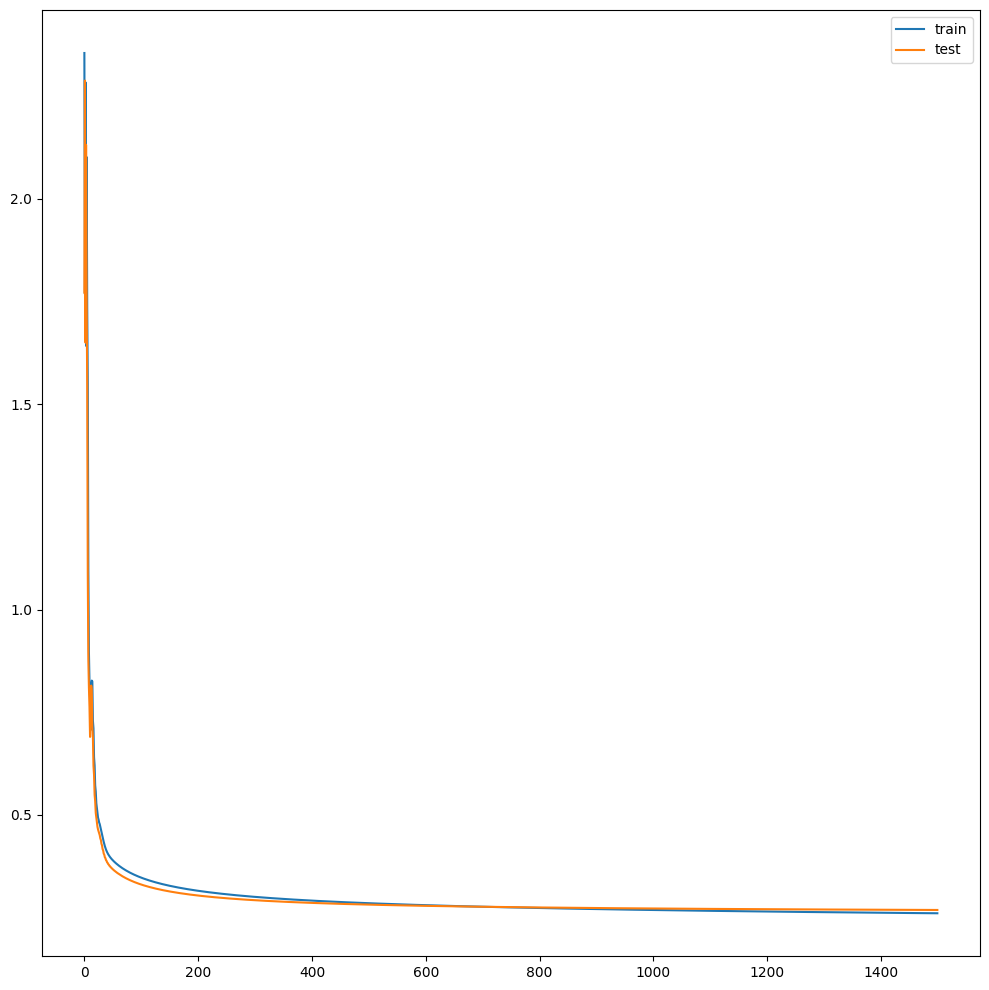

In [19]:
plt.figure(figsize=(10,10))
plt.plot(loss_list_train,label='train')
plt.plot(loss_list_test,label='test')
plt.legend()
plt.tight_layout()
plt.show()

## Train and Test Accuracy

In [20]:
# train accuracy
y_pred=torch.argmax(Y_hat,dim=1,keepdim=True)
train_acc=torch.sum(Y_train==y_pred)/Y_train.shape[0]


# test accuracy
Z_test=X_test@W+b
Y_hat_test=softmax(Z_test)
y_pred_test=torch.argmax(Y_hat_test,dim=1,keepdim=True)
test_acc=torch.sum(Y_test==y_pred_test)/Y_test.shape[0]

print(f"Train Accuracy: {train_acc}\
      \nTest Accuracy: {test_acc}")


Train Accuracy: 0.9280499815940857      
Test Accuracy: 0.9236000180244446


## Lets see what we got wrong prediction on 

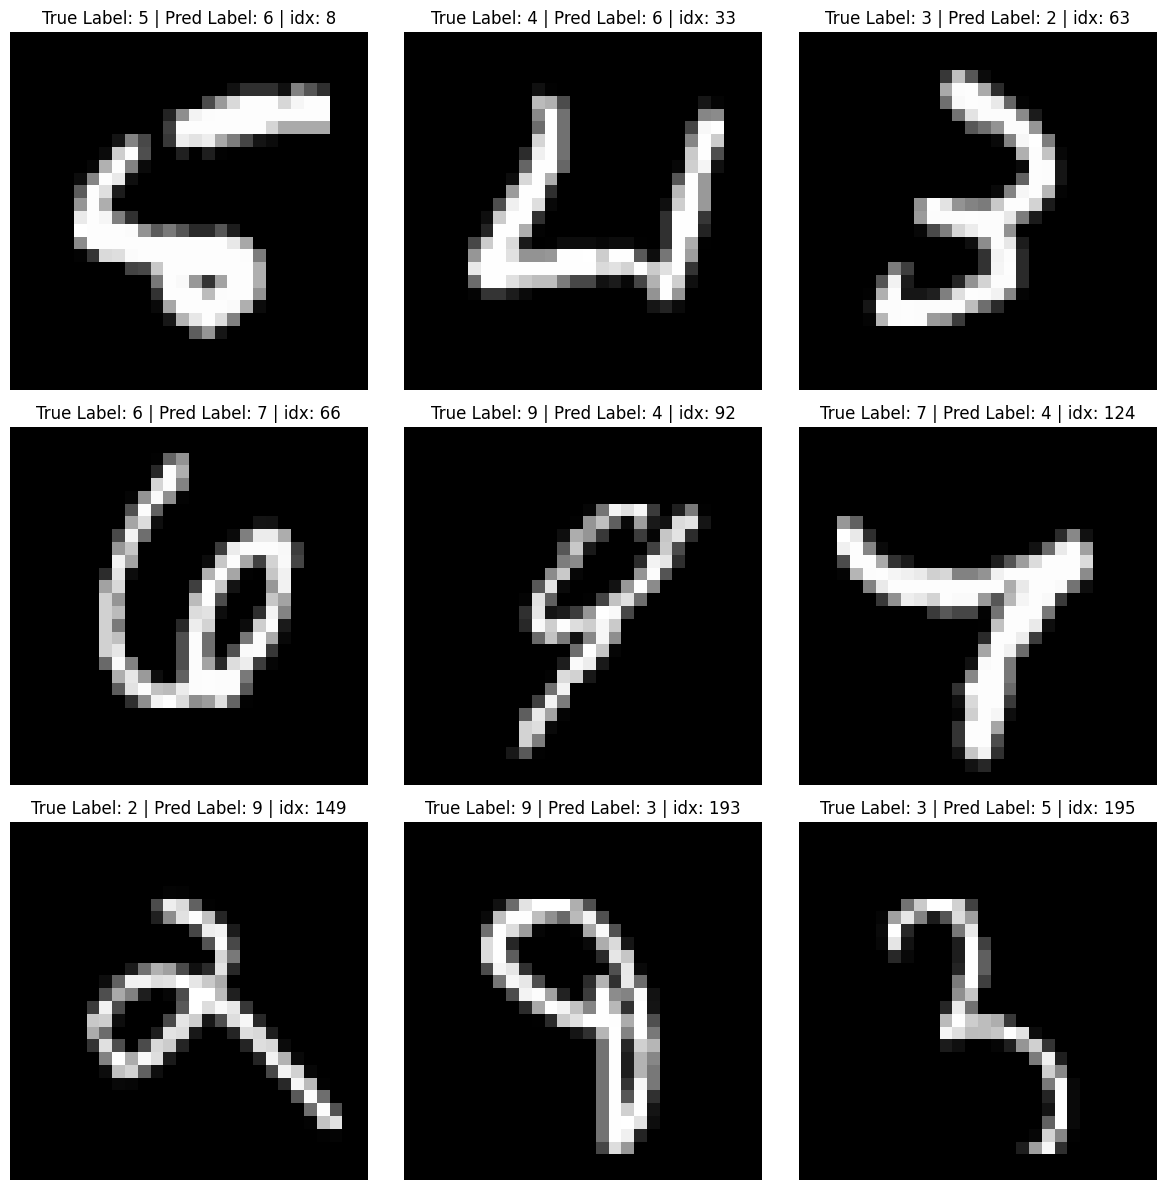

In [198]:
# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Plot images
c=-1
j=0
i=-1

end_loop=False
while i!=3:
    if end_loop:
        break
    i+=1
    j=0
    while j!=3:
        c+=1
        img, label = test_data[c]  # Accessing each image and label
        if label!=y_pred_test[c].item():
        # if label==8:
            axs[i, j].imshow(img.squeeze(),cmap='gray')
            axs[i, j].set_title(f'True Label: {label} | Pred Label: {y_pred_test[c].item()} | idx: {c}')
            axs[i, j].axis('off')  # Hide axis
            j+=1
        if((c==200) or (i==2 and j>2)):
            end_loop=True
            break

plt.tight_layout()
plt.show()

## Inferencing on a Custom Image Made in Paint

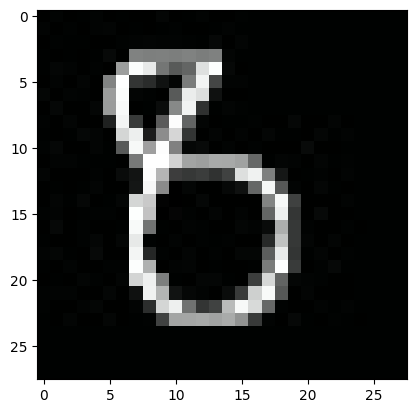

In [162]:
# inf_img=torch.tensor(plt.imread('/media/bikasherl/New Volume/Bajra_Tech/Week 4/image.jpg'))
inf_img=torch.tensor(plt.imread('/media/bikasherl/New Volume/Bajra_Tech/Week 4/image2.jpeg'))
# inf_img=torch.tensor(plt.imread('/media/bikasherl/New Volume/Bajra_Tech/Week 4/image3.jpeg'))
plt.imshow(inf_img)

In [163]:
inf_img=inf_img[:,:,0].flatten(0,1)
inf_img.shape

torch.Size([784])

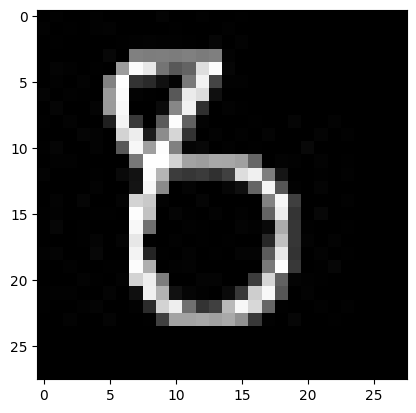

In [164]:
# scaling the image
inf_img=(inf_img-inf_img.min())/(inf_img.max()-inf_img.min())
plt.imshow(inf_img.view(28,28),cmap='gray')

In [165]:
# Prediction

Z_inf=inf_img@W+b
Y_hat_inf=softmax(Z_inf)
y_pred_inf=torch.argmax(Y_hat_inf,dim=1,keepdim=True)

print(f"The predicted digit is: {y_pred_inf.item()}")

The predicted digit is: 5


# EMNIST Dataset

In [166]:
train_edata=EMNIST(root='emnist_dataset/train/',split='balanced',train=True,download=True,transform=ToTensor())
test_edata=EMNIST(root='emnist_dataset/test/',split='balanced',train=False,download=True,transform=ToTensor())
train_edata,test_edata

(Dataset EMNIST
     Number of datapoints: 112800
     Root location: emnist_dataset/train/
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset EMNIST
     Number of datapoints: 18800
     Root location: emnist_dataset/test/
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [3]:
train_edata.class_to_idx

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'A': 10,
 'B': 11,
 'C': 12,
 'D': 13,
 'E': 14,
 'F': 15,
 'G': 16,
 'H': 17,
 'I': 18,
 'J': 19,
 'K': 20,
 'L': 21,
 'M': 22,
 'N': 23,
 'O': 24,
 'P': 25,
 'Q': 26,
 'R': 27,
 'S': 28,
 'T': 29,
 'U': 30,
 'V': 31,
 'W': 32,
 'X': 33,
 'Y': 34,
 'Z': 35,
 'a': 36,
 'b': 37,
 'd': 38,
 'e': 39,
 'f': 40,
 'g': 41,
 'h': 42,
 'n': 43,
 'q': 44,
 'r': 45,
 't': 46}

## Lets See How the Dataset Looks Like

80


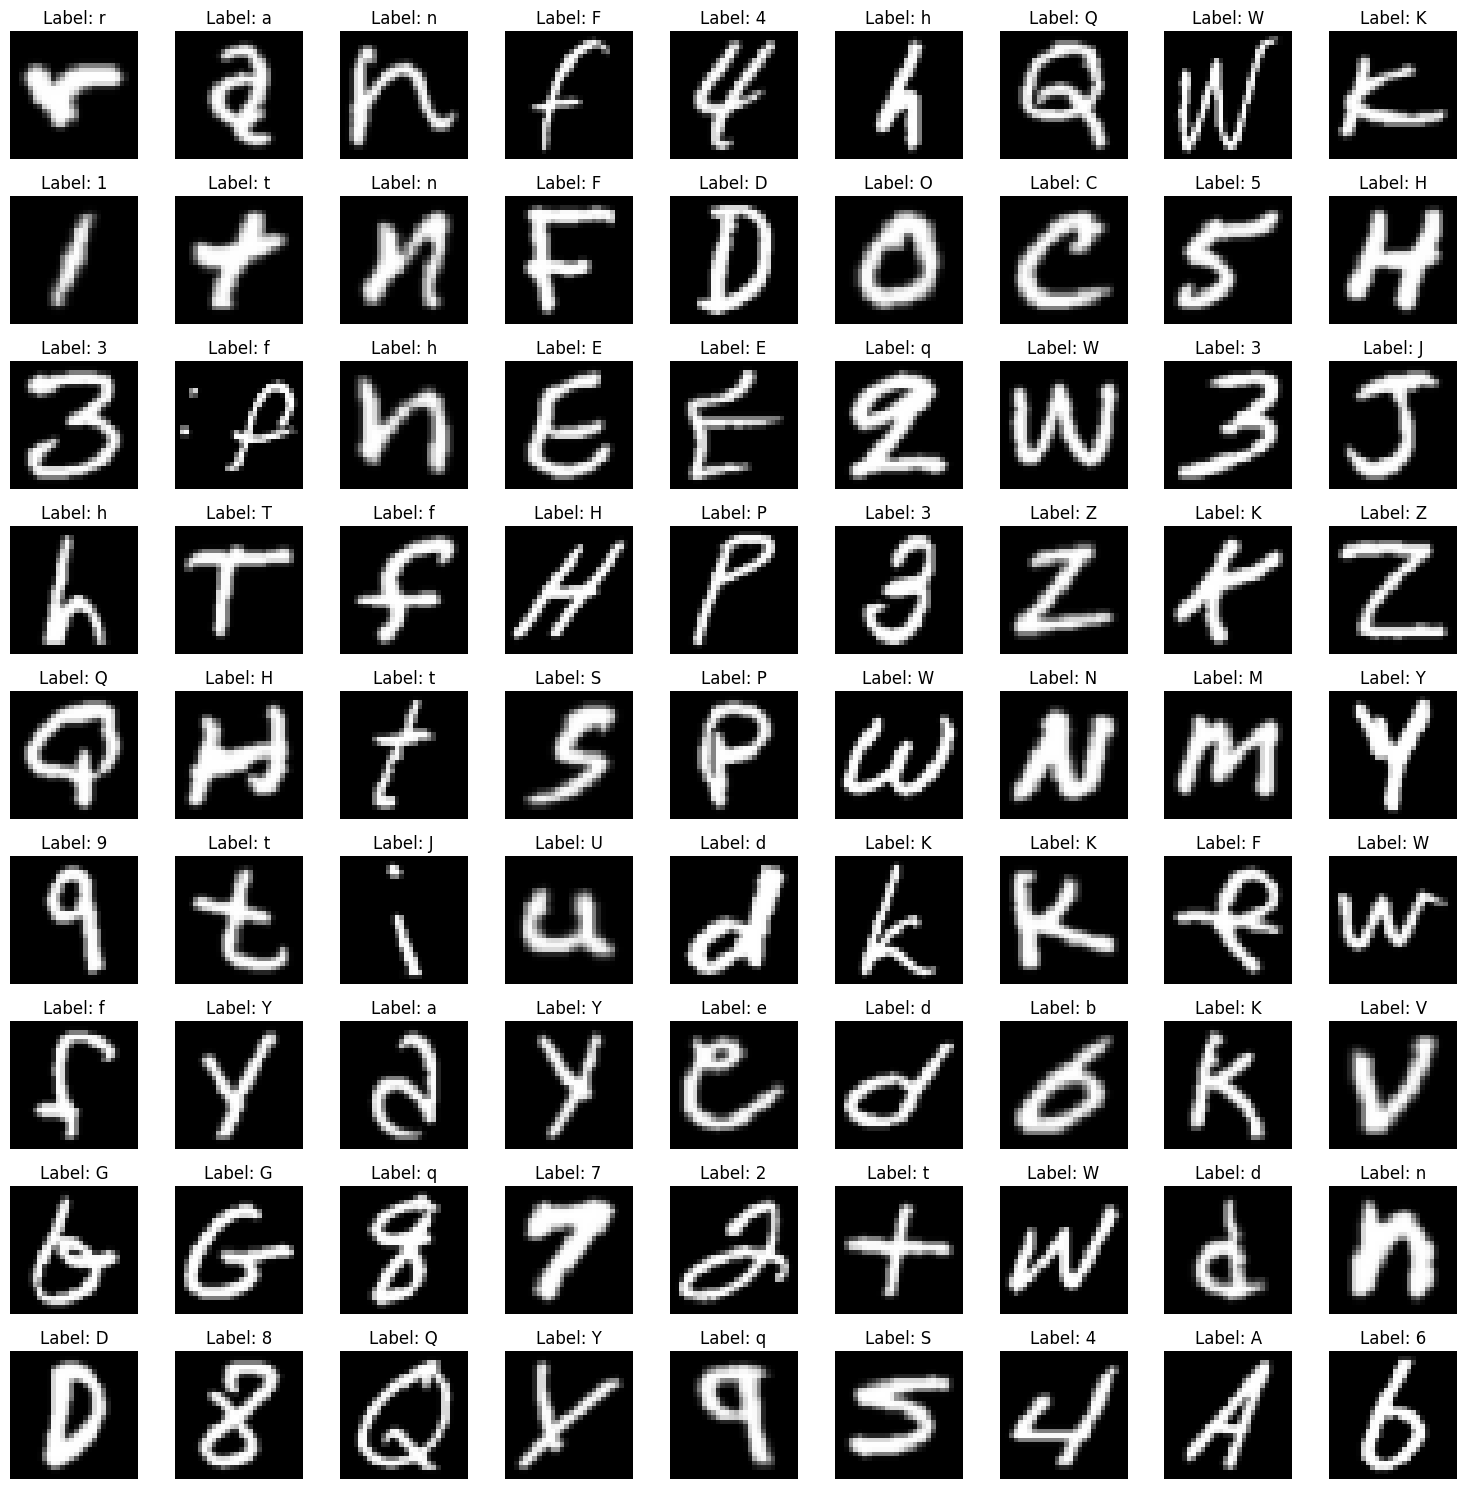

In [177]:
# Create subplots
fig, axs = plt.subplots(9, 9, figsize=(15, 15))

# Plot images
# Plot images
c=-1
j=0
i=-1

end_loop=False

while i!=9:
    if end_loop:
        print(c)
        break
    i+=1
    j=0
    while j!=9:
        c+=1
        img, label = train_edata[c]  # Accessing each image and label
        if list((train_edata.class_to_idx).keys())[label]:  #=='q':   can filter specific character
            axs[i, j].imshow(img.squeeze().T,cmap='gray')
            axs[i, j].set_title(f'Label: {list((train_edata.class_to_idx).keys())[label]}')
            axs[i, j].axis('off')  # Hide axis
            j+=1
        if((c==2000) or (i==8 and j>8)):  # could scan maximum of 2k images and minimum of 81 elements
            end_loop=True
            break        


plt.tight_layout()
plt.show()


## Train and Test Set Preparation

In [178]:
#train set
X_etrain=torch.flatten(train_edata.data,1,2).to(torch.float32)
Y_etrain=train_edata.targets.reshape(X_etrain.shape[0],1).to(torch.int8)

X_etrain.shape,Y_etrain.shape

# test set
X_etest=torch.flatten(test_edata.data,1,2).to(torch.float32)
Y_etest=test_edata.targets.reshape(X_etest.shape[0],1).to(torch.int8)

X_etrain.shape,Y_etrain.shape,X_etest.shape,Y_etest.shape

(torch.Size([112800, 784]),
 torch.Size([112800, 1]),
 torch.Size([18800, 784]),
 torch.Size([18800, 1]))

## Min max Scaling of Train and Test Data

In [179]:
# scaling train dataset
for i in range(X_etrain.shape[0]):
    X_etrain[i]=(X_etrain[i]-X_etrain[i].min())/(X_etrain[i].max()-X_etrain[i].min())


# scaling test dataset
for i in range(X_etest.shape[0]):
    X_etest[i]=(X_etest[i]-X_etest[i].min())/(X_etest[i].max()-X_etest[i].min())

In [180]:
Y_etrain[1]

tensor([36], dtype=torch.int8)

## One hot encoding for the labels

In [181]:
## One hot encoding For the labels

Y_enc_etrain=torch.zeros((Y_etrain.shape[0],len(train_edata.classes))).to(torch.int8)

for i in range(Y_etrain.shape[0]):
    Y_enc_etrain[i][Y_etrain[i].item()]=1


Y_enc_etest=torch.zeros((Y_etest.shape[0],len(test_edata.classes))).to(torch.int8)

for i in range(Y_etest.shape[0]):
    Y_enc_etest[i][Y_etest[i].item()]=1


Y_enc_etrain.shape,Y_enc_etest.shape

(torch.Size([112800, 47]), torch.Size([18800, 47]))

## Weights and Bias Initialization

In [185]:
# Weight and Bias Initialization

# # this one is for testing manually computed gradient
# w_etest=torch.randn((X_etrain.shape[1],Y_enc_etrain.shape[1]),dtype=torch.float64,requires_grad=True)
# b_etest=torch.randn((1,Y_enc_etrain.shape[1]),dtype=torch.float64,requires_grad=True)


# kaiming weight initialization
W=torch.randn((X_etrain.shape[1],Y_enc_etrain.shape[1]),dtype=torch.float32,requires_grad=False)*torch.sqrt(torch.tensor(2/X_etrain.shape[1]))
b=torch.randn((1,Y_enc_etrain.shape[1]),dtype=torch.float32,requires_grad=False)*0.01

W.shape,b.shape

(torch.Size([784, 47]), torch.Size([1, 47]))

## Softmax and Categorical Cross Entropy Loss Functions

In [186]:
def softmax(Z):
    return (torch.exp(Z)/torch.sum(torch.exp(Z),dim=1,keepdim=True))

def categorical_cross_entropy(Y_enc,Y_hat):
    return torch.sum((-Y_enc*torch.log(Y_hat)),dim=1,keepdim=True).mean()

loss_list_train=[]
loss_list_test=[]

## Training the Model

In [187]:
# Training Loop
for i in range(1000):
    Z=X_etrain@W+b

    Y_ehat=softmax(Z)
    Loss=categorical_cross_entropy(Y_enc_etrain,Y_ehat)

    loss_list_train.append(Loss.item())

    dL_dZ= (Y_ehat-Y_enc_etrain)/X_etrain.shape[0]
    dZ_dW= X_etrain


    dL_dW=dZ_dW.T@dL_dZ
    dL_db=torch.sum(dL_dZ,dim=0,keepdim=True)


    W-=1*dL_dW
    b-=1*dL_db


    Z_test=X_etest@W+b
    Y_hat_test=softmax(Z_test)
    Loss_test=torch.sum((-Y_enc_etest*torch.log(Y_hat_test)),dim=1,keepdim=True).mean()
    loss_list_test.append(Loss_test.item())



## Loss Curves

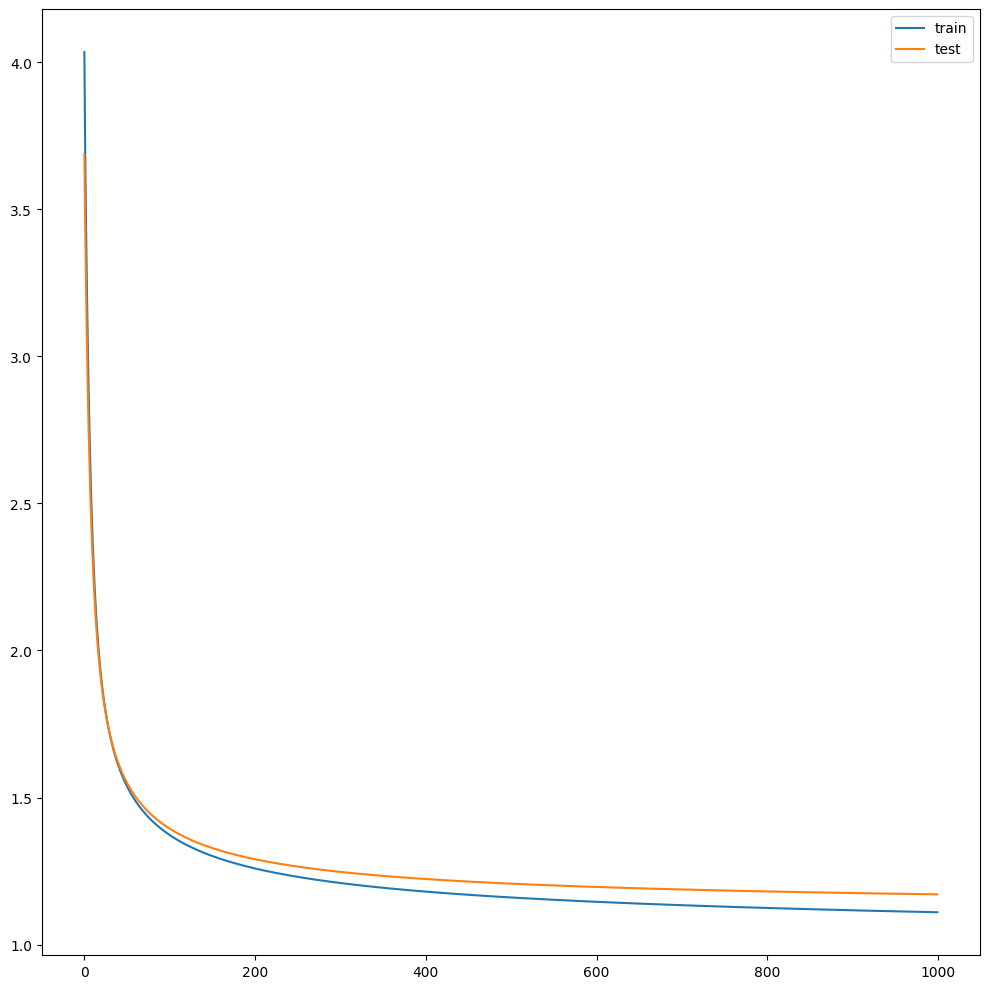

In [188]:
plt.figure(figsize=(10,10))
plt.plot(loss_list_train,label='train')
plt.plot(loss_list_test,label='test')
plt.legend()
plt.tight_layout()
plt.show()

## Train-Test Accuracy

In [189]:
# train accuracy
y_epred=torch.argmax(Y_ehat,dim=1,keepdim=True)
train_acc=torch.sum(Y_etrain==y_epred)/Y_etrain.shape[0]


# test accuracy
Z_etest=X_etest@W+b
Y_hat_etest=softmax(Z_etest)
y_pred_etest=torch.argmax(Y_hat_etest,dim=1,keepdim=True)
test_acc=torch.sum(Y_etest==y_pred_etest)/Y_etest.shape[0]

print(f"Train Accuracy: {train_acc}\
      \nTest Accuracy: {test_acc}")

Train Accuracy: 0.7007712721824646      
Test Accuracy: 0.6867552995681763


## Lets see what we got wrong prediction on

44


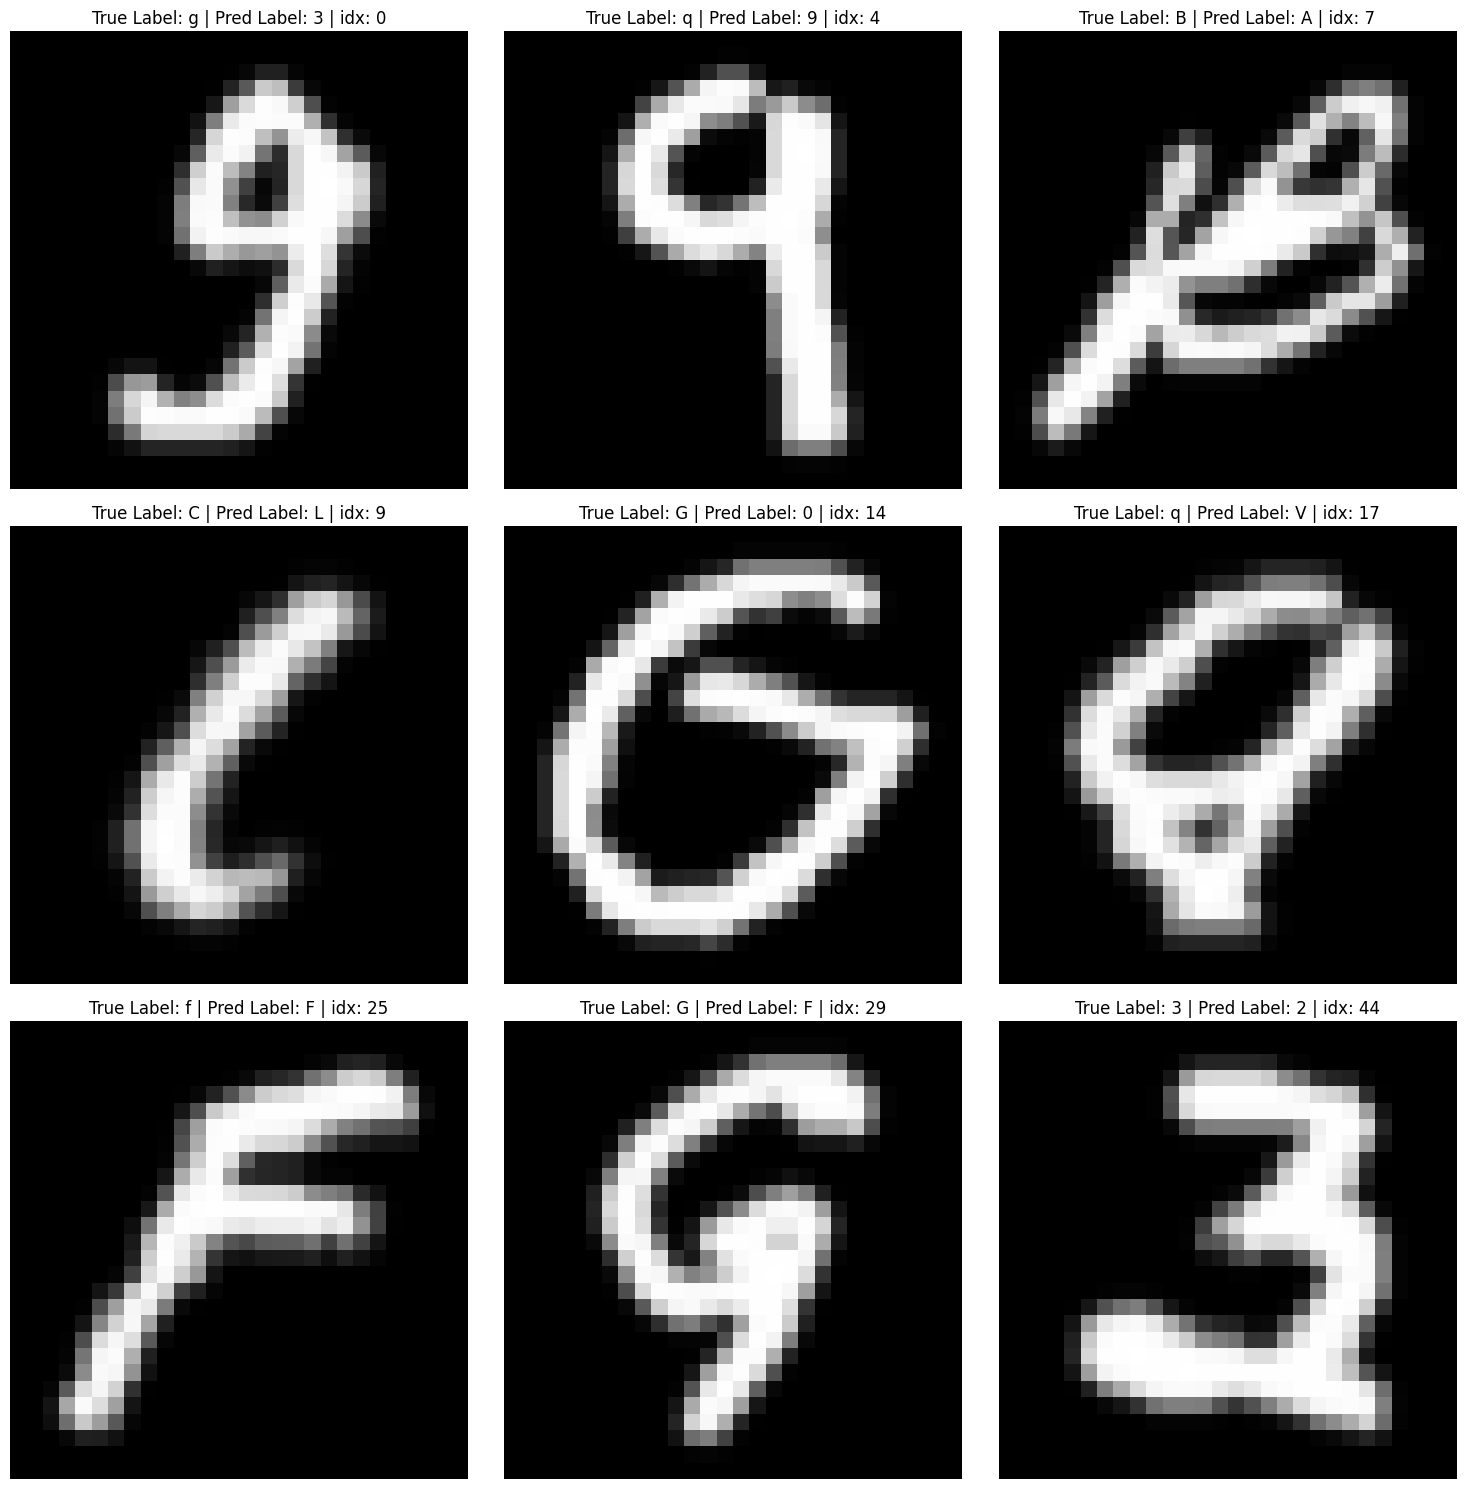

In [223]:
# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Plot images
# Plot images
c=-1
j=0
i=-1

end_loop=False

while i!=3:
    if end_loop:
        print(c)
        break
    i+=1
    j=0
    while j!=3:
        c+=1
        img, label = test_edata[c]  # Accessing each image and label
        if label!=y_pred_etest[c].item():
            axs[i, j].imshow(img.squeeze().T,cmap='gray')
            axs[i, j].set_title(f'True Label: {list((train_edata.class_to_idx).keys())[label]} | Pred Label: {list((train_edata.class_to_idx).keys())[y_pred_etest[c].item()]} | idx: {c}')
            axs[i, j].axis('off')  # Hide axis
            j+=1
        if((c==2000) or (i==2 and j>2)):  # could scan maximum of 2k images and minimum of 81 elements
            end_loop=True
            break        


plt.tight_layout()
plt.show()

## Inferencing on Custom Image

torch.Size([1, 784])


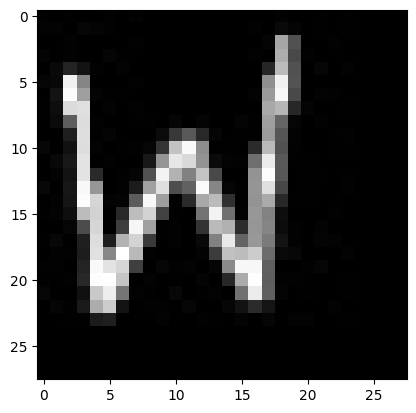

In [214]:
inf_img=torch.tensor(plt.imread('/media/bikasherl/New Volume/Bajra_Tech/Week 4/image4.jpeg'))

# flatten the image
inf_img=inf_img[:,:,0].flatten(0,1).reshape(1,-1)
print(inf_img.shape)
# scaling the image
inf_img=(inf_img-inf_img.min())/(inf_img.max()-inf_img.min())
plt.imshow(inf_img.view(28,28),cmap='gray')

In [215]:
# Prediction

Z_inf=inf_img@W+b
Y_hat_inf=softmax(Z_inf)
y_pred_inf=torch.argmax(Y_hat_inf,dim=1,keepdim=True)

print(f"The predicted character is: {list((train_edata.class_to_idx).keys())[y_pred_inf.item()]}")

The predicted character is: F
